In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS
from scipy.stats import ttest_ind
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns

# Problem:
In this problem set, we are going to examine data similar to the Pandora Ad Demand Paper.

In this project, we will move beyond treatment effects to investigate dosage, investigate how treatment effects change over time, use instrument variable to handle non-compliance in the experiment and Examine heterogeneous treatment effects.

We are for the first time going to examine an experiment where we care less about using the cells of an experiment and care more about the dosage of the treatment. 

# Setup:

Read in the file “pandora_ad_data.csv” to a dataframe named *df* 

I have provided a data dictionary below:
- **user_id**:  a unique identifier for each user
- **city**: the city a user resides in
- **sex**: the sex of the suer
- **age**: the age of the user (bucketed into 4 age groups)  ['13-17', '18-24', '25-54', '55+']
- **cell**: an integer 0-9 representing the cell the user was allocated to. Cell 0 is the control cell and cells 1-9 are different treatments
- **week** the week of the experiment for which we are looking at data
- **interruptions** the number of interruptions Pandora *intends* to deliver based on the cell designation
- **ads_per** the number of ads per interruption Pandora *intends* to deliver based on the cell designation
- **ad_min_actual** the number of minutes of ads per hour the Pandora actually delivered to the user in a week
- **play_min**: the number of minutes a user listened to Pandora in the week


In [ ]:
uploaded = files.upload()

Saving pandora_ad_data.csv to pandora_ad_data (2).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['pandora_ad_data.csv']))


For this problem we are going to examine only data at the end of an experiment. 
- i. Make a new dataframe, *df_end*, where we only take the data from the last week of the experiment. Use the “week” variable to find the last week, and subset the data to just that week. 
- ii. how many weeks are there in the experiment?
- iii. how many users are there per week?

In [ ]:
df.week.nunique()

112

In [ ]:
df.user_id.count()/df.week.nunique()

48000.0

In [ ]:
df_end = df.loc[df["week"]==df.week.max(),["user_id","city","sex","age","cell","week","interruptions","ads_per","ad_min_actual","play_min"]]
df_end

,user_id,city,sex,age,cell,week,interruptions,ads_per,ad_min_actual,play_min
111,0,Los Angeles,F,18-24,8,111,9,1.5,6.716641,0.000000
223,1,Tampa-St. Pete (Sarasota),F,18-24,0,111,4,1.5,3.454053,0.000000
335,2,Washington - DC (Hagrstwn),F,25-54,0,111,4,1.5,3.764045,0.000000
447,3,Atlanta,F,55+,9,111,6,2.0,4.701268,109.038297
559,4,Tampa-St. Pete (Sarasota),F,25-54,0,111,4,1.5,3.647815,58.821649
...,...,...,...,...,...,...,...,...,...,...
5375551,47995,Atlanta,F,25-54,2,111,3,1.5,1.042000,848.279509
5375663,47996,New York,M,25-54,6,111,4,2.0,4.511553,340.600506
5375775,47997,Miami-Ft. Lauderdale,F,18-24,8,111,9,1.5,6.318614,81.400090
5375887,47998,Boston (Manchester),F,25-54,6,111,4,2.0,4.084964,133.806808


There are total 112 weeks in the experiment; and 48,000 users/week.

We have 10 cells in this experiment, a control (Cell= 0) and 9 treatment cells.  For each cell in the experiment, calculate change in played minutes between control and that particular cell (hint, subset df_end into a dataframe that only has cell 0 and the comparison cell), and use a ** difference in means t-test**  to state whether the change was statistically significantly different from 0. 


In [ ]:
def getpval (df_end, y):
    Y_t = df_end.loc[df_end["cell"]==y,["play_min"]]
    Y_c = df_end.loc[df_end["cell"]==0,["play_min"]]
    t_stat, p_val = ttest_ind(Y_t,Y_c)
    return p_val

In [ ]:
m = []
for i in range(10):
    pval = getpval(df_end, i)
    m.append(pval)
print(m)

[array([1.]), array([0.32376464]), array([0.96983576]), array([0.86586377]), array([0.74151538]), array([0.77053117]), array([0.14233441]), array([0.50856853]), array([0.00024577]), array([0.00077675])]


In [ ]:
df_cell = pd.DataFrame(df_end.groupby("cell").play_min.mean())
cell_0 = df_end.loc[df["cell"]==0,"play_min"].mean()
df_cell["cell_0"] = cell_0
df_cell["Y_ATE"] = df_cell.play_min - df_cell.cell_0
df_cell["P_val"] = m
df_cell["interruptions"] = df_end.groupby("cell").interruptions.mean()
df_cell["ads_per"] = df_end.groupby("cell").ads_per.mean()
df_cell["treated_ad_min"] = df_cell.ads_per*df_cell.interruptions*0.5
df_cell["min_in_diff"] = df_cell.treated_ad_min - 3
df_cell

,play_min,cell_0,Y_ATE,P_val,interruptions,ads_per,treated_ad_min,min_in_diff
cell,,,,,,,,
0,341.799091,341.799091,0.000000,[1.0],4,1.5,3.00,0.00
1,348.523811,341.799091,6.724720,[0.32376464260048776],3,1.0,1.50,-1.50
2,342.053551,341.799091,0.254460,[0.9698357550619024],3,1.5,2.25,-0.75
3,340.672639,341.799091,-1.126452,[0.8658637665324558],3,2.0,3.00,0.00
4,344.024561,341.799091,2.225470,[0.7415153833925093],4,1.0,2.00,-1.00
5,339.837776,341.799091,-1.961315,[0.7705311656007489],4,1.5,3.00,0.00
6,331.929478,341.799091,-9.869613,[0.1423344122313477],4,2.0,4.00,1.00
7,337.351859,341.799091,-4.447233,[0.5085685287909367],6,1.0,3.00,0.00
8,317.296197,341.799091,-24.502895,[0.0002457688386733064],9,1.5,6.75,3.75


Only cell 8 and 9 were statistically significantly different from 0.

In df_end, I want to create new column with the expected ad load per hour named “treated_ad_min”, where you combine “ads_per” and “interruptions” to the total intended minutes of ads per hour. Assume each ad is 0.5 minutes (30 seconds) 


In [ ]:
df_end["treated_ad_min"] = df_end.ads_per*df_end.interruptions*0.5

In [ ]:
mod = smf.ols(formula='play_min ~ treated_ad_min', data=df_end)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               play_min   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     26.15
Date:                Sat, 26 Jun 2021   Prob (F-statistic):           3.17e-07
Time:                        23:41:08   Log-Likelihood:            -3.4625e+05
No. Observations:               48000   AIC:                         6.925e+05
Df Residuals:                   47998   BIC:                         6.925e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        359.1091      4.265     84.

Yes it is statistically significant at 95% confidence; and which means we expect that adding every 1 min in interruption of ad, users will decrease their playing time by 6.27 mins.

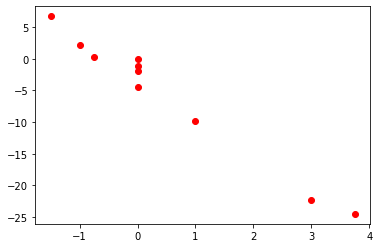

In [ ]:
plt.plot(df_cell.min_in_diff, df_cell.Y_ATE, 'ro')

Yes the coefficient of treated_ad_min is consistent with result in 1b (see graph above); and both of them showing of a negative slope between treated_ad_min and play_min.

Now we want to look at how the treatment effect changes over time. For this problem, we will need to use the entire dataset we read in the beginning. Re-create the “treated_ad_min” column that we did before in this data frame.


In [ ]:
df["treated_ad_min"] = df.ads_per*df.interruptions*0.5

The code below is designed to help us create a pandas dataframe that has each week as a row, and the estimated coefficient on treated_ad_min. 

In [ ]:
weeks =  df.week.nunique()

out = {"week":[],
       "coef":[]
      }

for i in range(weeks):
    df_small = df.loc[df["week"]==i,["play_min", "treated_ad_min"]] 
    mod = smf.ols(formula='play_min ~ treated_ad_min', data=df_small) 
    res = mod.fit()
    out["week"].append(i)
    out["coef"].append(res.params[1])

df_weekly_coef = pd.DataFrame(out)
df_weekly_coef

,week,coef
0,0,-0.651095
1,1,-0.331240
2,2,-0.443183
3,3,-0.244138
4,4,-1.176131
...,...,...
107,107,-5.721362
108,108,-6.223527
109,109,-7.523733
110,110,-5.690970


I provide a loop to plot the t-statistics of the treatment effect. Now we should have a dataframe named *df_ts* (short for dataframe t stats). I Plot the t-stat (y-axis) by week (x-axis).


In [ ]:
weeks =  df.week.nunique()

out = {"week":[],
       "t_stat":[]
      }

for i in range(weeks):
    df_small = df.loc[df["week"]==i,["play_min", "treated_ad_min"]] 
    mod = smf.ols(formula='play_min ~ treated_ad_min', data=df_small) 
    res = mod.fit()
    out["week"].append(i)
    out["t_stat"].append(res.tvalues[1])

df_weekly_tstat = pd.DataFrame(out)
df_weekly_tstat

,week,t_stat
0,0,-0.519725
1,1,-0.348340
2,2,-0.331432
3,3,-0.157944
4,4,-1.157872
...,...,...
107,107,-5.673212
108,108,-4.955175
109,109,-5.382871
110,110,-5.036432


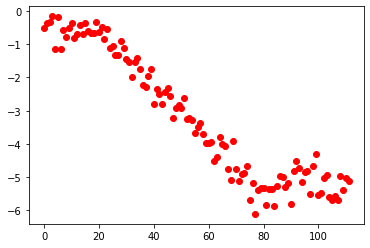

In [ ]:
plt.plot(df_weekly_tstat.week, df_weekly_tstat.t_stat, 'ro')

We will focus on results at the end of the experiment.

There are a lot of reasons why the enforced changes in ad load did not exactly match the adload that users received. 

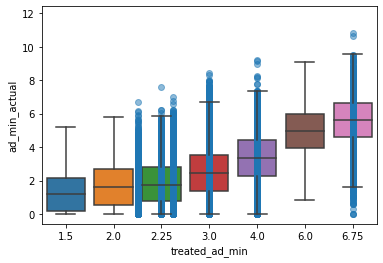

In [ ]:
plt.scatter(df_end.treated_ad_min, df_end.ad_min_actual, alpha=0.5)
sns.boxplot(x="treated_ad_min", y="ad_min_actual", data=df_end, showfliers = False)
plt.show()

Although there are large ranges (0->5) of ad_min_actual for users for every unique treated_ad_min; we still can see that the max and mean is getting biger as treated_ad_min getting larger.

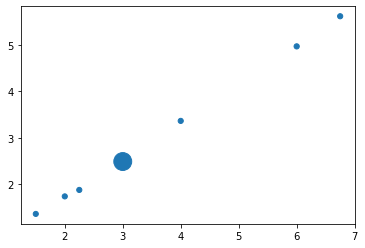

In [ ]:
plt.scatter(df_end.groupby("treated_ad_min").treated_ad_min.mean(), df_end.groupby("treated_ad_min").ad_min_actual.mean(), 
            s = df_end.groupby("treated_ad_min").user_id.count()/100)
plt.show()

In [ ]:
dose = {1.50:"a", 2.00:"b", 2.25:"c", 3.00:"d", 4.00:"e", 6.00:"f", 6.75:"g"}
df_end['dose'] = df_end.treated_ad_min.map(dose)
df_end_table = pd.DataFrame(df_end.groupby("dose").treated_ad_min.mean())
df_end_table["ad_min_actual"] = df_end.groupby("dose").ad_min_actual.mean()
df_end_table

,treated_ad_min,ad_min_actual
dose,,
a,1.50,1.360815
b,2.00,1.737821
c,2.25,1.876501
d,3.00,2.487349
e,4.00,3.361121
f,6.00,4.963919
g,6.75,5.611792


I run a regression where “ad_min_actual” is the outcome and  “treated_ad_min” is the independent variable. 
Then, I run a regression where “play_min” is the outcome and “treated_ad_min" is the independent variable.


In [ ]:
mod = smf.ols(formula='ad_min_actual ~ treated_ad_min', data=df_end)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          ad_min_actual   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                 2.234e+04
Date:                Sat, 26 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:42:39   Log-Likelihood:                -86602.
No. Observations:               48000   AIC:                         1.732e+05
Df Residuals:                   47998   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0449      0.019      2.

This means when treated_ad_min goes up 1 min, we expect ad_min_actual goes up 0.82 min. The r-squared is just 0.318, 32% of the variance in the ad_min_actual can be explained by the treated_ad_min, which is a little weak.

In [ ]:
mod = smf.ols(formula='play_min ~ treated_ad_min', data=df_end)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               play_min   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     26.15
Date:                Sat, 26 Jun 2021   Prob (F-statistic):           3.17e-07
Time:                        23:42:45   Log-Likelihood:            -3.4625e+05
No. Observations:               48000   AIC:                         6.925e+05
Df Residuals:                   47998   BIC:                         6.925e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        359.1091      4.265     84.

In [ ]:
B_rf = -6.2668
B_1s = 0.8197
B_ToT = B_rf/B_1s
B_ToT

-7.645236061973893

The Estimating Treatment Effect on Treated should be -7.6452; meaning if ad_min_actual goes up 1 min, we expect play_min goes down 7.645 mins.

In [ ]:
df_end['constant'] = 1
mod =IV2SLS(df_end.play_min, df_end[['constant', 'ad_min_actual']], df_end[['constant', 'treated_ad_min']])
res = mod.fit()
print(res.summary())

                          IV2SLS Regression Results                           
Dep. Variable:               play_min   R-squared:                       0.011
Model:                         IV2SLS   Adj. R-squared:                  0.011
Method:                     Two Stage   F-statistic:                     26.42
                        Least Squares   Prob (F-statistic):           2.76e-07
Date:                Sat, 26 Jun 2021                                         
Time:                        23:46:16                                         
No. Observations:               48000                                         
Df Residuals:                   47998                                         
Df Model:                           1                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant        359.4523      4.306     83.470

The model says when ad_min_actual goes up 1 min, we should expect play_min goes down 7.6456 mins; which is the same as the result in 3b.

Now we are going to look at heterogeneity by different subgroups. Notice that there are 3 variables which describe user attributes: sex, age, and city. We will focus on age for this.


I run a regression where *play_min* is our dependent variable and *treat_ad_min* is our independent variable. Interact *treated_ad_min* with age.

In [ ]:
dose = {"13-17":0, "18-24":1, "25-54":2, "55+":3}
df_end["age_dose"] = df_end.age.map(dose)
mod = smf.ols(formula='play_min ~ treated_ad_min*age_dose', data=df_end)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               play_min   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.00
Date:                Sat, 26 Jun 2021   Prob (F-statistic):           3.25e-07
Time:                        23:46:33   Log-Likelihood:            -3.4624e+05
No. Observations:               48000   AIC:                         6.925e+05
Df Residuals:                   47996   BIC:                         6.925e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [ ]:
mod = smf.ols(formula='play_min ~ treated_ad_min*age', data=df_end)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               play_min   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     763.6
Date:                Sat, 26 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:46:41   Log-Likelihood:            -3.4373e+05
No. Observations:               48000   AIC:                         6.875e+05
Df Residuals:                   47992   BIC:                         6.875e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

We don't have the same treatment effect per age group.

I then run a regression where *ad_min_actual* is our dependent variable and *treat_ad_min* is our independent variable but Interact *treated_ad_min* with *age*. 


In [ ]:
mod = smf.ols(formula='ad_min_actual ~ treated_ad_min*age', data=df_end)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          ad_min_actual   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     3884.
Date:                Sat, 26 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:47:05   Log-Likelihood:                -85000.
No. Observations:               48000   AIC:                         1.700e+05
Df Residuals:                   47992   BIC:                         1.701e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Looks like the 55+ group has a different ad load than others since the coef for age T.55+ is 0.0083 (far from 0.7), and coef for treated_ad_min:age T.55+ is negative.

I repeat the analysis for each of the 4 age groups individually. 


In [ ]:
df_end_1 = df_end.loc[df["age"]=='13-17',]
df_end_1['constant'] = 1
mod =IV2SLS(df_end_1.play_min, df_end_1[['constant', 'ad_min_actual']], df_end_1[['constant', 'treated_ad_min']])
res = mod.fit()
print(res.summary())

                          IV2SLS Regression Results                           
Dep. Variable:               play_min   R-squared:                       0.004
Model:                         IV2SLS   Adj. R-squared:                  0.004
Method:                     Two Stage   F-statistic:                    0.5438
                        Least Squares   Prob (F-statistic):              0.461
Date:                Sat, 26 Jun 2021                                         
Time:                        23:47:15                                         
No. Observations:                9665                                         
Df Residuals:                    9663                                         
Df Model:                           1                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant        259.6611      6.994     37.127

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def get_reduced_form (dfx):
    mod = smf.ols(formula='ad_min_actual ~ treated_ad_min', data=dfx)
    res = mod.fit()
    mod2 = smf.ols(formula='play_min ~ treated_ad_min', data=dfx)
    res2 = mod2.fit()
    B_rf = res2.params[1]
    B_1s = res.params[1]
    B_ToT = B_rf/B_1s
    return B_ToT

In [ ]:
get_reduced_form(df_end_1)

-2.107380329958182

In [ ]:
df_end_2 = df_end.loc[df["age"]=='18-24',]
df_end_2['constant'] = 1
mod =IV2SLS(df_end_2.play_min, df_end_2[['constant', 'ad_min_actual']], df_end_2[['constant', 'treated_ad_min']])
res = mod.fit()
print(res.summary())

                          IV2SLS Regression Results                           
Dep. Variable:               play_min   R-squared:                       0.020
Model:                         IV2SLS   Adj. R-squared:                  0.020
Method:                     Two Stage   F-statistic:                     10.85
                        Least Squares   Prob (F-statistic):           0.000992
Date:                Sat, 26 Jun 2021                                         
Time:                        23:51:38                                         
No. Observations:               14315                                         
Df Residuals:                   14313                                         
Df Model:                           1                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant        375.4609      8.251     45.505

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
get_reduced_form(df_end_2)

-8.567786975012629

In [ ]:
df_end_3 = df_end.loc[df["age"]=='25-54',]
df_end_3['constant'] = 1
mod =IV2SLS(df_end_3.play_min, df_end_3[['constant', 'ad_min_actual']], df_end_3[['constant', 'treated_ad_min']])
res = mod.fit()
print(res.summary())

                          IV2SLS Regression Results                           
Dep. Variable:               play_min   R-squared:                       0.023
Model:                         IV2SLS   Adj. R-squared:                  0.023
Method:                     Two Stage   F-statistic:                     16.11
                        Least Squares   Prob (F-statistic):           6.00e-05
Date:                Sat, 26 Jun 2021                                         
Time:                        23:51:56                                         
No. Observations:               16755                                         
Df Residuals:                   16753                                         
Df Model:                           1                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant        485.4117      8.310     58.410

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
get_reduced_form(df_end_3)

-10.61131379482532

In [ ]:
df_end_4 = df_end.loc[df["age"]=='55+',]
df_end_4['constant'] = 1
mod =IV2SLS(df_end_4.play_min, df_end_4[['constant', 'ad_min_actual']], df_end_4[['constant', 'treated_ad_min']])
res = mod.fit()
print(res.summary())

                          IV2SLS Regression Results                           
Dep. Variable:               play_min   R-squared:                       0.013
Model:                         IV2SLS   Adj. R-squared:                  0.013
Method:                     Two Stage   F-statistic:                     2.947
                        Least Squares   Prob (F-statistic):             0.0861
Date:                Sat, 26 Jun 2021                                         
Time:                        23:52:18                                         
No. Observations:                7265                                         
Df Residuals:                    7263                                         
Df Model:                           1                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant        173.3863      6.720     25.800

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
get_reduced_form(df_end_4)

-4.828340519582028

The group age 13-17 (-2.107) has the largest change in treatment effect to the result (-7.645).